In [570]:
import torch
import torch.nn as nn
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# 检查GPU是否可用
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [676]:
import pandas as pd

df = pd.read_csv('/Users/fanxinwei/Desktop/code/git_repo/dsmp-2024-group20/input_data/whole_dataset_300s.csv')
df = df.dropna()

In [678]:
# 将日期列转换为datetime对象
df['time'] = pd.to_datetime(df['time'])

# 创建代表早上8点的timedelta对象
eight_am = pd.to_timedelta('8 hours')

# 将秒转换为timedelta对象
df['time_window_x'] = pd.to_timedelta(df['time_window_x'], unit='s')

# 将日期和时间相加
df['datetime'] = df['time'] + eight_am + df['time_window_x']
#设置datetime为索引
df.set_index('datetime', inplace=True)
#删除不需要的列
df.drop(['time', 'time_window_x'], axis=1, inplace=True)
# 'max_bid', 'min_ask', 'avg_price','bid_level_diff', 'ask_level_diff', 'bid_cumulative_depth', 'ask_cumulative_depth','bid_ask_depth_diff', 
feature=df[['max_bid', 'min_ask', 'avg_price','bid_level_diff', 'ask_level_diff', 'bid_cumulative_depth', 'ask_cumulative_depth','bid_ask_depth_diff']]
target=df['avg_price']

In [679]:
from sklearn.preprocessing import StandardScaler

train_size = int(len(feature) * 0.8)
X_train, X_test = feature.iloc[:train_size], feature.iloc[train_size:]
y_train, y_test = target.iloc[:train_size], target.iloc[train_size:]

# 数据标准化
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [680]:
def create_sequences(input_data, target_data, sequence_length):
    sequences = []
    targets = []
    for i in range(len(input_data) - sequence_length):
        sequences.append(input_data[i:i+sequence_length])
        targets.append(target_data.iloc[i+sequence_length])
    return torch.FloatTensor(sequences), torch.FloatTensor(targets)

sequence_length = 10
X_train_sequences, y_train_sequences = create_sequences(X_train_scaled, y_train, sequence_length)
X_test_sequences, y_test_sequences = create_sequences(X_test_scaled, y_test, sequence_length)

In [683]:
from torch.utils.data import Dataset, DataLoader, TensorDataset

# 假设 X_train_sequences 和 y_train_sequences 已经是预处理好的数据张量
train_dataset = TensorDataset(X_train_sequences, y_train_sequences)

# 创建 DataLoader
train_loader = DataLoader(
    dataset=train_dataset,   # 提供加载的数据集
    batch_size=32,           # 每个批次的大小
    shuffle=False            # 是否在每个epoch开始时打乱数据 
)

X_test_sequences = torch.FloatTensor(X_test_sequences)
y_test_sequences = torch.FloatTensor(y_test_sequences)
test_dataset = TensorDataset(X_test_sequences, y_test_sequences)
test_loader = DataLoader(
    dataset=test_dataset, 
    batch_size=32, 
    shuffle=False
)



In [684]:
import torch
import torch.nn as nn

class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim=1, num_layers=1, dropout_rate=0.0):
        super(LSTMModel, self).__init__()
        # 定义LSTM层
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout_rate)
        # 定义输出层
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # 获取批次大小
        batch_size = x.size(0)
        # 初始化隐藏状态和细胞状态
        hidden_state = torch.zeros(self.lstm.num_layers, batch_size, self.lstm.hidden_size).to(x.device)
        cell_state = torch.zeros(self.lstm.num_layers, batch_size, self.lstm.hidden_size).to(x.device)
        
        out, _ = self.lstm(x, (hidden_state, cell_state))
        out = self.fc(out[:, -1, :])
        return out.squeeze()




In [685]:
import torch.optim as optim
# 模型参数
input_dim = feature.shape[1]  # 输入特征维数
hidden_dim = 20  # LSTM隐藏层维数
output_dim = 1  # 输出维数，假设我们在做回归预测
num_layers = 2  # LSTM层数
dropout_rate = 0.2  # Dropout比率，有助于防止过拟合

# 实例化模型，并将其转移到合适的设备（GPU或CPU）
model = LSTMModel(input_dim, hidden_dim, output_dim, num_layers, dropout_rate).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [686]:
# 训练模型
import torch

def train_model(model, criterion, optimizer, train_loader, num_epochs=10, device=device):
    model.train()  # 确保模型处于训练模式
    model.to(device)  # 确保模型已转移到适当的设备上

    for epoch in range(num_epochs):
        total_loss = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()  # 清空过去的梯度
            outputs = model(inputs)  # 前向传播
            loss = criterion(outputs, labels)  # 计算损失
            loss.backward()  # 反向传播
            optimizer.step()  # 更新参数

            total_loss += loss.item() * inputs.size(0)  # 更新总损失

        avg_loss = total_loss / len(train_loader.dataset)  # 计算平均损失
        print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss:.4f}')

    print("Training complete.")


In [691]:
train_model(model, criterion, optimizer, train_loader, num_epochs=50)

Epoch 1/50, Loss: 2391.2987
Epoch 2/50, Loss: 2185.9635
Epoch 3/50, Loss: 1992.8415
Epoch 4/50, Loss: 1813.1302
Epoch 5/50, Loss: 1648.8697
Epoch 6/50, Loss: 1496.2104
Epoch 7/50, Loss: 1357.1947
Epoch 8/50, Loss: 1228.1636
Epoch 9/50, Loss: 1107.2932
Epoch 10/50, Loss: 998.5115
Epoch 11/50, Loss: 900.6119
Epoch 12/50, Loss: 809.5889
Epoch 13/50, Loss: 727.9051
Epoch 14/50, Loss: 650.9824
Epoch 15/50, Loss: 583.8690
Epoch 16/50, Loss: 527.5734
Epoch 17/50, Loss: 472.6816
Epoch 18/50, Loss: 431.8336
Epoch 19/50, Loss: 382.3355
Epoch 20/50, Loss: 344.0684
Epoch 21/50, Loss: 310.2335
Epoch 22/50, Loss: 283.4451
Epoch 23/50, Loss: 263.2900
Epoch 24/50, Loss: 258.6164
Epoch 25/50, Loss: 216.5129
Epoch 26/50, Loss: 198.3699
Epoch 27/50, Loss: 180.3729
Epoch 28/50, Loss: 166.1013
Epoch 29/50, Loss: 152.9258
Epoch 30/50, Loss: 142.8523
Epoch 31/50, Loss: 132.0850
Epoch 32/50, Loss: 122.7288
Epoch 33/50, Loss: 114.1283
Epoch 34/50, Loss: 107.7881
Epoch 35/50, Loss: 101.8896
Epoch 36/50, Loss: 9

In [692]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_squared_error,mean_squared_log_error
import numpy as np

def validate_model(model, test_loader, criterion, device):
    model.eval()  # 设置模型为评估模式
    total_loss = 0.0
    all_predictions = []
    all_targets = []

    with torch.no_grad():  # 在评估阶段关闭梯度计算
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * inputs.size(0)

            # 收集所有预测和目标值，用于后续的计算
            all_predictions.extend(outputs.cpu().numpy())
            all_targets.extend(labels.cpu().numpy())

    # 计算平均损失
    avg_loss = total_loss / len(test_loader.dataset)
    print(f'Average Loss: {avg_loss:.4f}')

    # 计算其他评估指标
    all_predictions = np.array(all_predictions).flatten()  # 确保是一维数组
    all_targets = np.array(all_targets).flatten()

    # 计算MAE
    mae = mean_absolute_error(all_targets, all_predictions)
    print(f'Mean Absolute Error: {mae:.4f}')
    
    mse = mean_squared_error(all_targets, all_predictions)
    print(f'Mean Squared Error: {mse:.4f}')
    
    msle = mean_squared_log_error(all_targets, all_predictions)
    print(f'Mean Squared Log Error: {msle:.4f}')

    # 计算RMSE
    rmse = np.sqrt(mean_squared_error(all_targets, all_predictions))
    print(f'Root Mean Squared Error: {rmse:.4f}')

    # 计算R² Score
    r2 = r2_score(all_targets, all_predictions)
    print(f'R² Score: {r2:.4f}')
    
    all_predictions = np.array(all_predictions).flatten()
    all_targets = np.array(all_targets).flatten()

    # 返回预测结果和实际标签，以及平均损失
    return all_predictions, all_targets


In [693]:
predictions,targets=validate_model(model, test_loader, criterion,device)

Average Loss: 106.4864
Mean Absolute Error: 9.1931
Mean Squared Error: 106.4864
Mean Squared Log Error: 0.0052
Root Mean Squared Error: 10.3192
R² Score: -2.0797


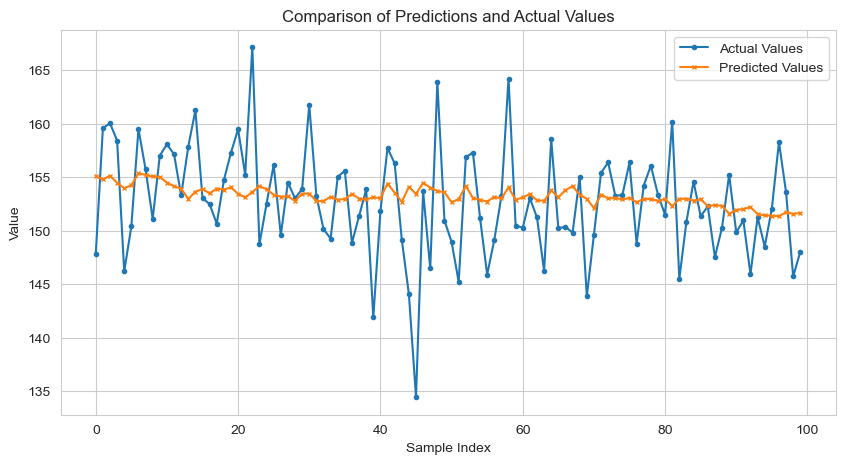

In [694]:
import matplotlib.pyplot as plt

num_points = 100  # 设置显示的数据点数量
predictions_subset = predictions[:num_points]
targets_subset = targets[:num_points]
# 绘制预测值和实际值
plt.figure(figsize=(10, 5))  # 设置图形的大小
plt.plot(targets_subset, label='Actual Values', marker='o',markersize=3)  # 实际值
plt.plot(predictions_subset, label='Predicted Values', marker='x',markersize=3)  # 预测值
plt.title('Comparison of Predictions and Actual Values')  # 图形标题
plt.xlabel('Sample Index')  # x轴标签
plt.ylabel('Value')  # y轴标签
plt.legend()  # 显示图例
plt.grid(True)  # 显示网格
plt.show()  # 显示图形


In [671]:
torch.save(model.state_dict(), '/Users/fanxinwei/Desktop/code/git_repo/dsmp-2024-group20/output_data/oneday_lstm.pth')